# Research sandbox

Optimal velocity function: 

$V:s \mapsto V(s),$ \
$V(s) = \max\{0, \ v_0 -v_0\exp(-\lambda v_0^{-1}(s -s_0)) \},$ \
$V'(s) = H(s -s_0)\lambda\exp(-\lambda v_0^{-1}(s -s_0)),$ \
$V^{-1}(v) = -\lambda^{-1}v_0 \log(1-v_0^{-1}v)+s_0,\ 0<v<v_0.$

Heterogeneous OV Model with Relaxed Noise: 

$\begin{equation}
  \begin{cases}
    \dot \varepsilon_n = -b^{-1}\varepsilon_n +a \xi_n,\\
    \dot v_n = \tau_n^{-1}[{w(V_n+\varepsilon_n)-v_n}],\\
    \dot x_n = v_n,
  \end{cases}
\end{equation}$

$
\begin{equation}
  \begin{cases}
  \varepsilon_n(t+\delta) = (1-\delta b^{-1})\varepsilon_n(t) + a\sqrt{\delta} \eta_n,\ \eta_n \sim \mathcal{N}(0,\,1),\\
    v_n(t+\delta) = v_n(t) + \delta \tau_n^{-1}[{w(V_n +\varepsilon_n(t+\delta))-v_n(t)}],\\
    x_n(t+\delta) = x_n(t) + \delta v_n(t+\delta).
  \end{cases}
\end{equation}$

Anticipatory Operational Navigation: 

$\begin{equation}
  f(\alpha)=\min\{d_{\max}, v_0 \Delta t(\alpha)\}
\end{equation}$
 $\begin{equation}
     \alpha_0=\begin{cases}
    0,&\max\{f(\alpha^-),f(\alpha^+)\}=d_{\max}\\
\mathrm{argmax} {f(\alpha)},&\max\{f(\alpha^-),f(\alpha^+)\}<d_{\max}\\
    \end{cases}
\end{equation}$
$\begin{equation}
  \dot \alpha = \tau^{-1}\left[\alpha_0-\alpha\right]
\end{equation}$

In [1]:
import json
import os
import warnings
import zipfile

import ijson
import powerlaw

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm

In [3]:
from numpy import arange, array, degrees, diff, mean, nan, sign, unique, where
from math import cos, sin
from numpy.linalg import norm
from numpy.polynomial import Polynomial
from numpy.random import default_rng
from powerlaw import pdf, power_law_ks_distance
from scipy.optimize import minimize
from scipy.stats import linregress

In [4]:
from scipy.stats import binned_statistic

In [5]:
from pNeuma_simulator import params
from pNeuma_simulator.animations import ring

from pNeuma_simulator.gang import decay
from pNeuma_simulator.initialization import ov

from pNeuma_simulator.results import percolate, polarize

In [6]:
warnings.filterwarnings("ignore")
rcParams.update(
    {
        "pdf.fonttype": 42,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "Helvetica"],
        "mathtext.fontset": "stix",
        "mathtext.default": "regular",
        "font.size": 7,
        "axes.titlesize": 7,
        "xtick.labelsize": 6,
        "ytick.labelsize": 6,
        "axes.linewidth": 0.25,
        "xtick.major.width": 0.25,
        "ytick.major.width": 0.25,
        "xtick.minor.width": 0.25,
        "ytick.minor.width": 0.25,
    }
)
# LaTeX packages
plt.rc("text", usetex=False)
plt.rc(
    "text.latex",
    preamble=r"\usepackage{amsmath}",
)
plt.rc("text.latex", preamble=r"\usepackage{gensymb}")
dark_blue = "#1964B0"
dark_teal = "#008A69"
vermilion = "#DB5829"
orange = "#F4A637"
maroon = "#894B45"
dark_purple = "#882D71"
light_purple = "#D2BBD7"
grey = "#DEDEDE"

In [7]:
# probe = False
# if probe:
#     permutation = (4, 6)
#     items = loader(permutation, path)
#     accidents = 0
#     locations = []
#     for item in items:
#         if isinstance(item[0], list):
#             pass
#         else:
#             locations.append(item)
#             accidents += 1
#     error = accidents / len(items)
#     print(error)

In [8]:
path = "./output/"
os.makedirs(path, exist_ok=True)

## Simulated powerlaw distribution

In [8]:
verbose = True
howmany = 8
l_ttc = []
for permutation in [(14, 2), (14, 4), (14, 6), (14, 8)]:
    with zipfile.ZipFile(f"{path}{permutation}.zip", "r") as ziph:
        # ziph is zipfile handle
        for filename in ziph.namelist():
            if filename.endswith(").json"):
                # Opening JSON file
                with ziph.open(filename, "r") as openfile:
                    # Reading from JSON file
                    # https://pythonspeed.com/articles/json-memory-streaming/
                    for n, item in enumerate(tqdm(ijson.items(openfile, "item"))):
                        if n < howmany:
                            # items.append(item)
                            if isinstance(item[0], list):
                                for _, agents in enumerate(item[0]):
                                    for agent in agents:
                                        ttc = agent["ttc"]
                                        if ttc:
                                            l_ttc.append(agent["ttc"])
                        else:
                            break
                    # items = json.load(openfile)
                    if verbose:
                        print(openfile.name)

0it [00:00, ?it/s]

(14, 2).json


0it [00:00, ?it/s]

(14, 4).json


0it [00:00, ?it/s]

(14, 6).json


0it [00:00, ?it/s]

(14, 8).json


In [9]:
ttc_data = array(l_ttc).astype(float)
len(ttc_data)

679938

In [10]:
results = powerlaw.Fit(ttc_data, xmin=18.003454683291505)

In [11]:
results.xmin, results.sigma, results.alpha

(18.003454683291505, 0.0014194904558849444, 1.7834648647912184)

In [12]:
ks = power_law_ks_distance(ttc_data, results.alpha, results.xmin)
ks

0.0075037758740931215

In [14]:
max(ttc_data)

507345394.36973375

In [26]:
edges, hist = pdf(ttc_data, linear_bins=True, xmin=results.xmin, xmax=10000)
bin_centers = (edges[1:] + edges[:-1]) / 2.0
hist[hist == 0] = nan

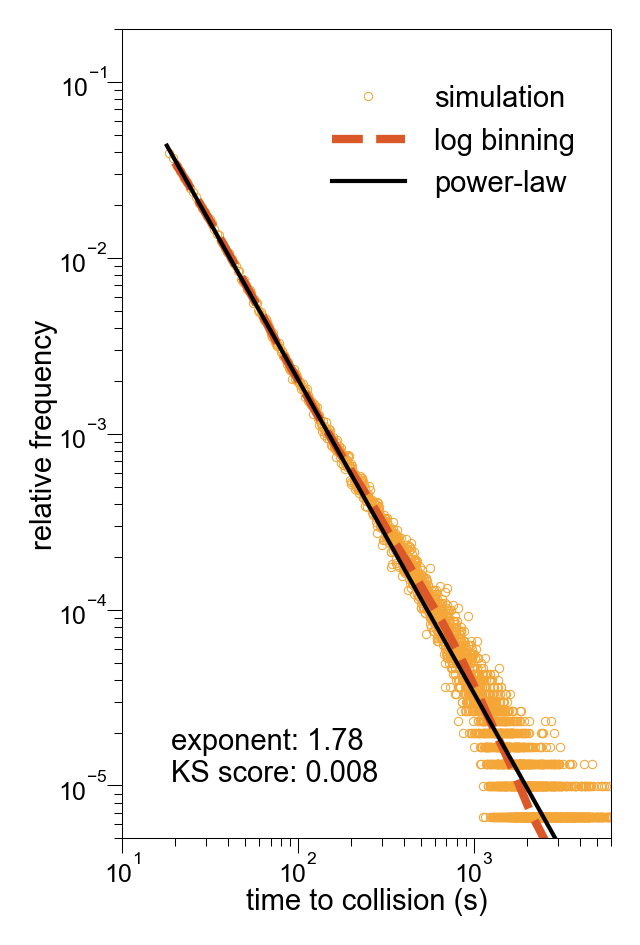

In [ ]:
fig, ax = plt.subplots(figsize=(5 * params.cm, 7.5 * params.cm), dpi=300)
ax.set_aspect("equal")
# results.plot_pdf(
#    ax=ax,
#    linear_bins=True,
#    color=orange,
#    lw=0,
#    marker=".",
#    markerfacecolor="none",
#    markeredgewidth=0.25,
#    ms=4,
#    ls="-",
#    label="simulation",
# )
ax.plot(
    bin_centers,
    hist,
    color=orange,
    lw=0,
    marker=".",
    markerfacecolor="none",
    markeredgewidth=0.25,
    ms=4,
    ls="-",
    label="simulation",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
results.plot_pdf(ax=ax, linear_bins=False, c=vermilion, lw=2, ls="--", label="log binning")
results.power_law.plot_pdf(c="k", linestyle="-", lw=1, ax=ax, label="power-law")
ax.set_ylabel("relative frequency", labelpad=0)
ax.set_xlabel("time to collision (s)", labelpad=0)
ax.tick_params(axis="x", pad=0)
ax.tick_params(axis="y", pad=0)
ax.set_xlim(1e1, 6e3)
ax.set_ylim(5e-6, 2e-1)
ax.legend(
    frameon=False,
    borderpad=0,
    handletextpad=1,
    handlelength=2.5,
    fontsize=7,
    loc=2,
    bbox_to_anchor=(0.4, 0.95),
)
ax.text(
    0.1,
    0.1,
    f"exponent: {round(results.alpha,2)}\nKS score: {round(ks,3)}",
    fontsize=7,
    ha="left",
    va="center",
    transform=ax.transAxes,
)
fig.tight_layout(pad=0)
plt.savefig(
    "/Users/georg/Documents/Figures/ttc_sim.pdf",
    format="pdf",
    transparent=True,
)
plt.show()

## Phase-transition and scaling

In [9]:
n_cars = 12
n_moto = 6
permutation = (n_cars, n_moto)

In [10]:
# def loader(permutation, verbose=True):
verbose = True
items = []
with zipfile.ZipFile(f"{path}{permutation}_r.zip", "r") as ziph:
    # ziph is zipfile handle
    for filename in ziph.namelist():
        if filename.endswith(").jsonl"):
            # Opening JSONL file
            with ziph.open(filename, "r") as openfile:
                # Reading from JSONL file
                # https://stackoverflow.com/questions/2081836/
                for i, line in enumerate(tqdm(openfile)):
                    item = json.loads(line)
                    if isinstance(item[0], list):
                        items.append(item)
                if verbose:
                    print(openfile.name)
#   return items

0it [00:00, ?it/s]

(12, 6).jsonl


In [11]:
len(items)

64

In [12]:
# Pseudorandom number generator
seed = 1
rng = default_rng(seed)
NU = 1.096854  # theoretical exponent for directed percolation in 1D

In [13]:
def loss(x, y, x_star):
    renorm = np.abs(x - x_star)
    slope, _, _, _, _ = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
    return abs(NU - slope)

In [14]:
def fit(x, y):
    # https://stackoverflow.com/questions/3843017/
    zero_crossings = where(diff(sign(y)))[0]
    x0 = x[zero_crossings[0]]
    # https://stackoverflow.com/questions/24767191/
    res = minimize(lambda x_star: loss(x, y, x_star), method="Nelder-Mead", x0=x0)
    popt = res.x[0]
    return popt

In [15]:
percolation = percolate(items[:], n_cars, n_moto, rng, start=5)

In [16]:
polarization = polarize(items[:], n_cars, n_moto, rng, start=5)

In [17]:
x_, y_, low_, high_ = polarization
x_, y_, low_, high_ = array(x_), array(y_), array(low_), array(high_)
yerr_ = np.array(list(zip(y_ - low_, high_ - y_))).T

In [18]:
x, y, low, high, cumulant = percolation
x, y, low, high, cumulant = array(x), array(y), array(low), array(high), array(cumulant)
yerr = np.array(list(zip(y - low, high - y))).T
T_c = fit(array(x), y)
renorm = abs(T_c - x)
slope, intercept, r_value, p_value, std_err = linregress(np.log(renorm)[y > 0], np.log(y[y > 0]))
print(abs(NU - slope), T_c, r_value**2)

3.2566482881524195e-06 41.99454689025879 0.9983210610894644


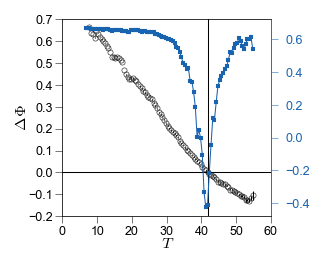

In [19]:
fig, ax = plt.subplots(figsize=(5 * params.cm, 4 * params.cm), dpi=150)
ax2 = ax.twinx()
_ = ax2.plot(x, cumulant, "-s", ms=1, lw=0.5, c=dark_blue, zorder=0)
ax.errorbar(
    x,
    y,
    yerr=yerr,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.25,
    ecolor="k",
    elinewidth=0.5,
    label="$\\langle \\Delta\\Phi \\rangle$",
)
# ax.text(
#    0.4,
#    0.06,
#    "$\\langle \\Delta\\Phi \\rangle$",
#    ha="right",
#    va="bottom",
#    fontsize=7,
#    transform=ax.transAxes,
#    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
#    usetex=True,
#    zorder=10,
# )
# ax.text(
#    0.3,
#    0.18,
#    "$T_c$",
#    ha="right",
#    va="bottom",
#    fontsize=7,
#    transform=ax.transAxes,
#    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
#    usetex=True,
#    zorder=10,
# )
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, 0.6)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axhline(0, c="k", lw=0.5, zorder=500)
ax.axvline(
    T_c,
    c="k",
    lw=0.5,
    ls="-",
    label="$T_c$",
    zorder=500,
)
ax.set_xlabel("$T$", usetex=True, labelpad=0)
ax.set_ylabel("$\\Delta\\Phi$", usetex=True, labelpad=0)
# ax.legend(
#    loc=[0, 0.015],
#    frameon=False,
#    handletextpad=0.5,
#    handlelength=1.5,
#    fontsize=7,
# )
ax2.spines["right"].set_edgecolor(dark_blue)
ax2.tick_params(axis="y", colors=dark_blue)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

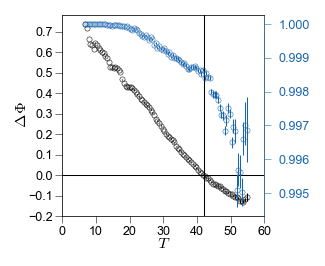

In [20]:
fig, ax = plt.subplots(figsize=(5 * params.cm, 4 * params.cm), dpi=150)
ax2 = ax.twinx()
ax2.errorbar(
    x_,
    y_,
    yerr=yerr_,
    ms=5,
    fmt=".",
    mec=dark_blue,
    mfc="none",
    mew=0.25,
    ecolor=dark_blue,
    elinewidth=0.5,
    label="polarization",
)
ax.errorbar(
    x,
    y,
    yerr=yerr,
    ms=5,
    fmt=".",
    mec="k",
    mfc="none",
    mew=0.25,
    ecolor="k",
    elinewidth=0.5,
    label="$\\langle \\Delta\\Phi \\rangle$",
)
# ax.text(
#    0.4,
#    0.06,
#    "$\\langle \\Delta\\Phi \\rangle$",
#    ha="right",
#    va="bottom",
#    fontsize=7,
#    transform=ax.transAxes,
#    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
#    usetex=True,
#    zorder=10,
# )
# ax.text(
#    0.3,
#    0.18,
#    "$T_c$",
#    ha="right",
#    va="bottom",
#    fontsize=7,
#    transform=ax.transAxes,
#    bbox=dict(facecolor="w", edgecolor="w", boxstyle="round,pad=.1"),
#    usetex=True,
#    zorder=10,
# )
ax.set_xlim(0, 60)
ax.set_ylim(-0.2, None)
ax.set_xticks(arange(0, 70, 10))
ax.set_yticks(arange(-0.2, 0.8, 0.1))
ax.axhline(0, c="k", lw=0.5, zorder=500)
ax.axvline(
    T_c,
    c="k",
    lw=0.5,
    ls="-",
    label="$T_c$",
    zorder=500,
)
ax.set_xlabel("$T$", usetex=True, labelpad=0)
ax.set_ylabel("$\\Delta\\Phi$", usetex=True, labelpad=0)
# ax.legend(
#    loc=[0, 0.015],
#    frameon=False,
#    handletextpad=0.5,
#    handlelength=1.5,
#    fontsize=7,
# )
ax2.spines["right"].set_edgecolor(dark_blue)
ax2.tick_params(axis="y", colors=dark_blue)
ax.tick_params(axis="x", pad=1)
ax.tick_params(axis="y", pad=1)
fig.tight_layout(pad=0)
# plt.savefig(f"percolation.pdf", format="pdf", transparent=True)

In [21]:
def draw_law(x, y, r_value, save=False):
    fig, ax = plt.subplots(figsize=(4 * params.cm, 4 * params.cm), dpi=150)
    ax.set_aspect("equal")
    _ = plt.loglog(
        x[y > 0],
        y[y > 0],
        ".",
        mec="k",
        mfc="none",
        ms=5,
        mew=0.25,
    )
    p_fitted = Polynomial.fit(np.log(x[y > 0]), np.log(y[y > 0]), deg=1)
    plt.plot(
        np.exp(unique(np.log(x)[y > 0])),
        np.exp(p_fitted(unique(np.log(x)[y > 0]))),
        c="k",
        ls="-",
        lw=0.5,
    )
    ax.text(
        0.05,
        0.95,
        f"$R^2$= {r_value:.3f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.07,
        0.8,
        f"$\\nu$= {slope:.4f}",
        ha="left",
        va="top",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.2,
        f"$T_c$= {T_c:.2f}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.text(
        0.95,
        0.05,
        f"permutation {permutation}",
        ha="right",
        va="bottom",
        fontsize=7,
        transform=ax.transAxes,
        usetex=True,
    )
    ax.set_ylabel("$\\langle \\Delta \\Phi \\rangle^+$", usetex=True, labelpad=0)
    ax.set_xlabel("$|T-T_c|$", usetex=True, labelpad=0)
    ax.tick_params(axis="x", pad=0)
    ax.tick_params(axis="y", pad=0)
    fig.tight_layout(pad=0)
    if save:
        plt.savefig(
            # f"./power-laws/power-law{permutation}.pdf", format="pdf", transparent=True
            f"./power-law{permutation}.pdf",
            format="pdf",
            transparent=True,
        )

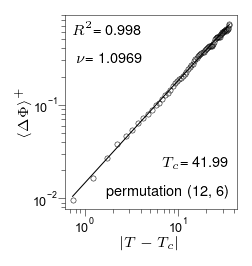

In [22]:
draw_law(renorm, y, r_value**2, save=False)

In [23]:
def inner_loop(frame, v_max):
    deg_range = []
    vel_car = []
    vel_x = []
    vel_y = []
    for j, _ in enumerate(frame):
        speed = frame[j]["speed"]
        theta = frame[j]["theta"]
        if j <= 2 * n_cars - 1:
            vel_car.append(speed / v_max[j])
        else:
            alphas = decay(speed, theta)
            degs = degrees(alphas)
            deg_range.append(degs[0] - degs[-1])
            vel_x.append(speed * cos(theta) / v_max[j])
            vel_y.append(speed * sin(theta) / v_max[j])
        phi_cars = mean(vel_car)
        phi_moto = norm([sum(vel_x), sum(vel_y)]) / n_moto
    return deg_range, phi_cars, phi_moto

In [24]:
start = int(len(item[0]) * 2 / 3 - 1)
start

5999

In [25]:
l_n = []
for n, item in enumerate(items):
    if isinstance(item[0], list):
        l_T = []
        l_DPhi = []
        frames = []
        n_veh = 2 * n_cars + n_moto
        lam = np.empty(shape=n_veh, dtype=float)
        v0 = np.empty(shape=n_veh, dtype=float)
        s0 = np.empty(shape=n_veh, dtype=float)
        for t, frame in enumerate(item[0]):
            if t == 0:
                for j, _ in enumerate(frame):
                    v0[j] = frame[j]["v0"]
                    lam[j] = frame[j]["lam"]
                    s0[j] = frame[j]["s0"]
            v_max = ov(params.d_max, lam, v0, s0)
            if t > start:
                deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
                if round(mean(deg_range)) == int(2 * T_c):
                    frames.append(t)
                    l_T.append(mean(deg_range))
                    l_DPhi.append(phi_moto - phi_cars)
        l_T = np.round(l_T) / 2
        if len(l_T) > 0:
            print(n, len(l_T))
            l_n.append(n)

17 117
25 34
29 45
40 28
41 55
45 40
49 79
53 98
57 9
62 26


In [26]:
start = 0
item = items[53]

In [27]:
item[0][0][-6]

{'theta': 0.0,
 'speed': 0.0,
 'ttc': None,
 'lam': 2.503346865184171,
 'v0': 11.594887210223051,
 's0': 0.9043219497430913,
 'pos': [-41.57911361195592, 1.771216560931172]}

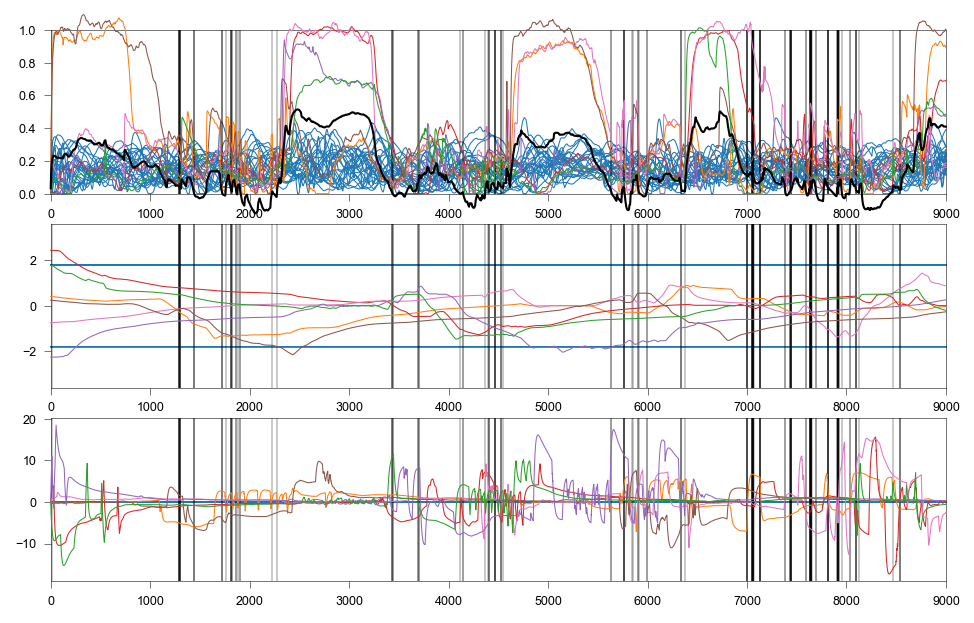

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(16 * params.cm, 10 * params.cm), dpi=150)
n_veh = 2 * n_cars + n_moto
lam = np.empty(shape=n_veh, dtype=float)
v0 = np.empty(shape=n_veh, dtype=float)
s0 = np.empty(shape=n_veh, dtype=float)
frame = item[0][0]
for j, _ in enumerate(frame):
    v0[j] = frame[j]["v0"]
    lam[j] = frame[j]["lam"]
    s0[j] = frame[j]["s0"]
v_max = ov(params.d_max, lam, v0, s0)
ar = array(item[0])
for i in range(ar.shape[1]):
    speeds = []
    lateral = []
    thetas = []
    for d in ar[start::1, -(i + 1)]:
        speed = d["speed"] / v_max[-(i + 1)]
        speeds.append(speed)
        y = d["pos"][1]
        lateral.append(y)
        theta = d["theta"]
        thetas.append(degrees(theta))
    if i <= n_moto - 1:
        zorder = 10
        c = "tab:orange"
        if i == 1:
            c = "tab:red"
            zorder = 100
        elif i == 2:
            c = "tab:pink"
            zorder = 100
        elif i == 3:
            c = "tab:brown"
            zorder = 100
        elif i == 4:
            c = "tab:purple"
            zorder = 100
        elif i == 5:
            c = "tab:green"
            zorder = 100
    else:
        zorder = 0
        c = "tab:blue"
    axs[0].plot(speeds, c=c, lw=0.5, clip_on=False, zorder=zorder)
    axs[1].plot(lateral, c=c, lw=0.5, clip_on=False, zorder=zorder)
    axs[2].plot(thetas, c=c, lw=0.5, clip_on=False, zorder=zorder)
if n_moto > 0:
    l_DPhi = []
    for t, frame in enumerate(item[0]):
        if t > start:
            deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
            l_DPhi.append(phi_moto - phi_cars)
            if round(mean(deg_range)) == int(2 * T_c):
                axs[0].axvline(t - start, c="k", ls="-", lw=0.2)
                axs[1].axvline(t - start, c="k", ls="-", lw=0.2)
                axs[2].axvline(t - start, c="k", ls="-", lw=0.2)
                # print(t - start)
    axs[0].plot(l_DPhi, c="k", lw=1, clip_on=False, zorder=100)
axs[2].set_xlim(0, ar.shape[0])  # - (start + 1))
axs[1].set_xlim(0, ar.shape[0])  # - (start + 1))
axs[0].set_xlim(0, ar.shape[0])  # - (start + 1))
axs[0].set_ylim(0, 1)
axs[1].set_ylim(-params.lane, params.lane)
fig.tight_layout(pad=0)

In [189]:
from scipy.signal import find_peaks

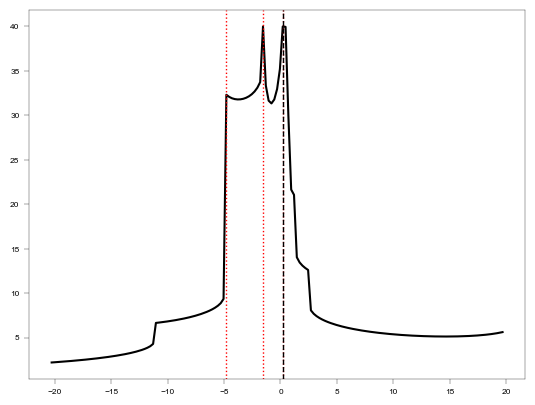

In [ ]:
item = items[30]
t = 0
index = -1
for t in range(1, len(item[0]) - 1):
    speed = item[0][t - 1][index]["speed"]
    theta = item[0][t - 1][index]["theta"]
    f_a = item[0][t][index]["f_a"]
    optima = find_peaks(item[0][t][index]["f_a"])[0]
    peaks = array(f_a)[optima]
    alphas = decay(speed, theta)
    choices = alphas[optima]
    maxima = np.argwhere(peaks == max(peaks)).flatten()
    indices = optima[maxima]
    if len(indices) > 1:
        optimum = indices[np.argmin(abs(alphas[indices]))]
        a0 = alphas[optimum]
        break
    else:
        optimum = indices[0]
        a0 = alphas[optimum]
plt.plot(degrees(alphas), f_a, c="k")
for choice in degrees(choices):
    _ = plt.axvline(choice, c="r", lw=1, ls=":")
_ = plt.axvline(degrees(a0), c="k", lw=1, ls="--")

In [ ]:
t_list = []
n_veh = 2 * n_cars + n_moto
lam = np.empty(shape=n_veh, dtype=float)
v0 = np.empty(shape=n_veh, dtype=float)
s0 = np.empty(shape=n_veh, dtype=float)
for t, frame in enumerate(item[0]):
    if t == 0:
        for j, _ in enumerate(frame):
            v0[j] = frame[j]["v0"]
            lam[j] = frame[j]["lam"]
            s0[j] = frame[j]["s0"]
    v_max = list(ov(params.d_max, lam, v0, s0))
    if t > start:
        for j, _ in enumerate(frame):
            deg_range, phi_cars, phi_moto = inner_loop(frame, v_max)
        if np.round(mean(deg_range)) == int(2 * T_c):
            t_list.append(t)

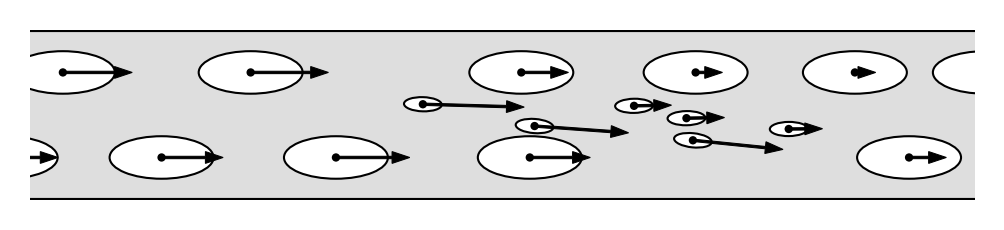

In [30]:
# item = items[59]
xmin = -5
xmax = 35
t = 4000  # 7918  # t_list[0]
fig, ax = plt.subplots(figsize=(8 * params.cm, 2 * params.cm), dpi=300)
ax.set_aspect("equal")
ring(t, n_cars, item[0], ax)
ax.set_xlim(xmin, xmax)
ax.tick_params(axis="both", direction="in", pad=0)
ax.axvspan(xmin, xmax, facecolor=grey, zorder=-1)
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(
#    "/Users/georg/Documents/Figures/active.pdf",
#    format="pdf",
#    transparent=True,
# )

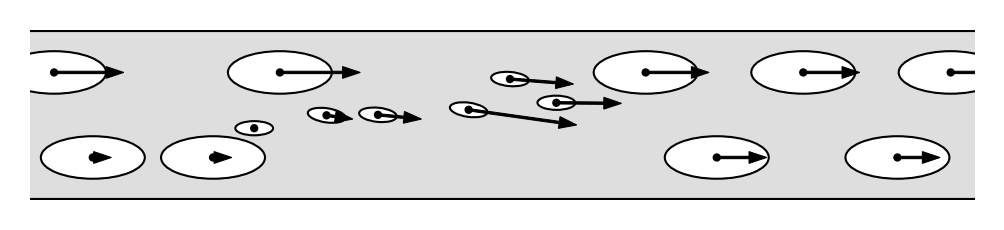

In [86]:
item = items[l_n[0]]
xmin = -35
xmax = 5
t = t_list[0]
fig, ax = plt.subplots(figsize=(8 * params.cm, 2 * params.cm), dpi=300)
ax.set_aspect("equal")
ring(t, n_cars, item[0], ax)
ax.set_xlim(xmin, xmax)
ax.tick_params(axis="both", direction="in", pad=0)
ax.axvspan(xmin, xmax, facecolor=grey, zorder=-1)
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(
#    "/Users/georg/Documents/Figures/active.pdf",
#    format="pdf",
#    transparent=True,
# )

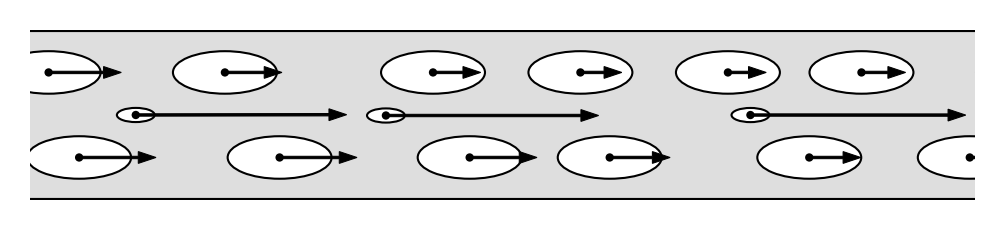

In [ ]:
item = items[l_n[3]]
xmin = 0.5
xmax = 40.5
t = 8750
fig, ax = plt.subplots(figsize=(8 * params.cm, 2 * params.cm), dpi=300)
ax.set_aspect("equal")
ring(t, n_cars, item[0], ax)
ax.set_xlim(xmin, xmax)
ax.tick_params(axis="both", direction="in", pad=0)
ax.axvspan(xmin, xmax, facecolor=grey, zorder=-1)
ax.set_axis_off()
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig(
#    "/Users/georg/Documents/Figures/absorbing.pdf",
#    format="pdf",
#    transparent=True,
#)

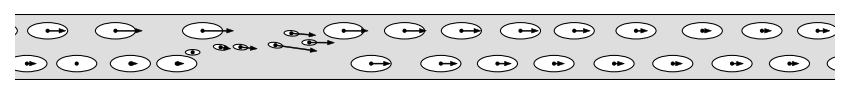

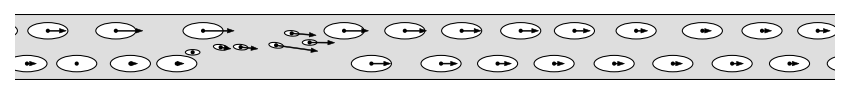

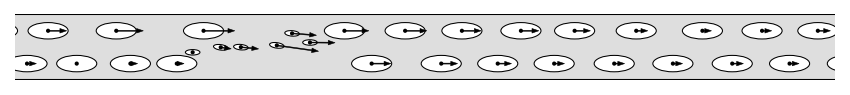

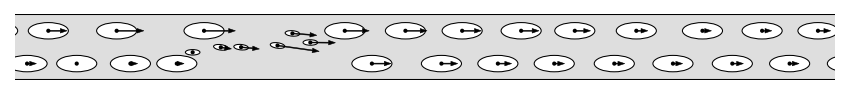

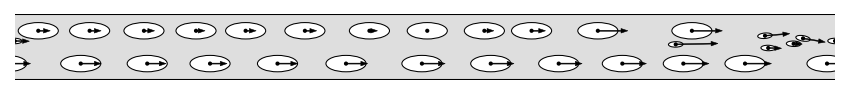

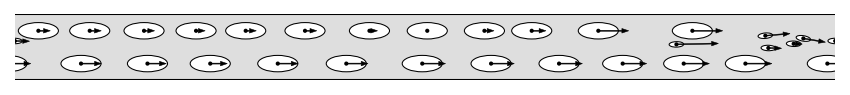

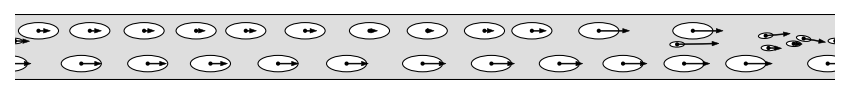

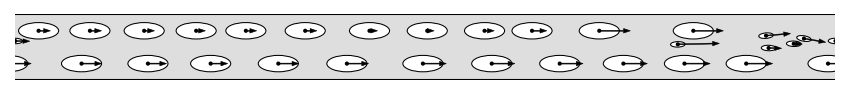

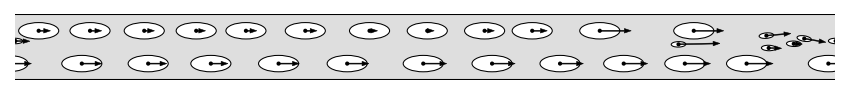

In [74]:
item = items[l_n[0]]
for t in t_list[:]:
    fig, ax = plt.subplots(figsize=(14.7 * params.cm, 2.5 * params.cm), dpi=150)
    fig.tight_layout(pad=0)
    ax.set_aspect("equal")
    ax.axvspan(-params.L / 2, params.L / 2, facecolor=grey, zorder=-1)
    ring(t, n_cars, item[0], ax)